# Network Analysis

This is a set of repeated functions required everytime we're analyzing a graph. Useful for code reuse and keeping things clean.

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

clstr_product_path = '../data/cluster_descriptions/cluster_product.csv'
clstr_product_df=pd.read_csv(clstr_product_path, index_col=0)   

In [2]:
def transform_cluster_to_product(cluster_name):
    #match it ffrom clstr_poduct_df from the index
    cluster = clstr_product_df.loc[cluster_name]
    product=cluster['product_name']
    
    return product

def compute_network_stats(G, network_name="G"):

    if type(G) == str:
        #if its given a gml file path
        G = nx.read_gml(G)

    components = nx.connected_components(G)

    largest_cc = max(components, key=len)
    largest_cc_subgraph = G.subgraph(largest_cc)

    communities = nx.algorithms.community.louvain_communities(G)

    stats = {
        "Name": network_name,
        "|V|": G.number_of_nodes(),
        "|E|": G.number_of_edges(),
        "density": nx.density(G),
        "k": np.mean(list(dict(G.degree()).values())),
        "k weighted": np.mean(list(dict(G.degree(weight='weight')).values())),
        "|components|": nx.number_connected_components(G),
        "cc": nx.average_clustering(G),
        "s_path": nx.average_shortest_path_length(largest_cc_subgraph),
        "d": nx.diameter(largest_cc_subgraph),
        "|communities|": len(list(communities)),
        "Q": nx.community.modularity(G, communities),
        "r_squared": plot_log_log(G, weighted=True, plot=False)
    }

    stats_df = pd.DataFrame(stats, index=[0])
    stats_df.set_index("Name", inplace=True)
    
    return stats_df

def plot_degree_distribution(G, network_name='',weighted=False):
    if not weighted:
        degrees = [G.degree(n) for n in G.nodes()]
        plt.hist(degrees, bins=30,color='lightblue')
        plt.title(network_name)
        plt.show()
    else:
        degrees = [G.degree(n, weight='weight') for n in G.nodes()]
        plt.hist(degrees, bins=30, label=network_name)
        plt.title(network_name)
        plt.show()

def plot_log_log(G, network_name='', weighted=False, plot=True):
    '''
    takes a graph, computes log log degree distribution
    if plot is F, it returns only the r squared of the least squares applied on the log log deg dist

    param:
    -------
        * G: nx.Graph
        * network_name (optional): str, if want to give the plot a title
        * weighted (optional): bool, if  it takes into consideration the weighted degrees instead
        * plot (optional), if want to show a plot ot not
    '''
    if weighted:
        degrees = [G.degree(n, weight='weight') for n in G.nodes()]
    else:
        degrees = [G.degree(n) for n in G.nodes()]

    log_pk = np.log(np.unique(degrees, return_counts=True)[1])
    log_k = np.log(np.unique(degrees, return_counts=True)[0])

    x,y = log_k, log_pk

    ### regression line
    slope, intercept = np.polyfit(x, y, 1)
    # print(f"SLope: {slope*-1}, intercept: {intercept}")
    r_squared = 1 - (sum((y - (slope * x + intercept))**2) / ((len(y) - 1) * np.var(y)))

    if plot:
        plt.title(f"{network_name}; R sq: {round(r_squared,5)}")
        plt.xlabel("log(k)")
        plt.ylabel("log(p(k))")

        plt.scatter(log_k, log_pk)
        plt.plot(x, slope * x + intercept, color="red")
        plt.show()

    return r_squared

def get_top_n_nodes_centrality(G, centrality_dict, n=10, with_values=False, centrality_name=None):
    sorted_degrees = sorted(centrality_dict.items(), key=lambda x: x[1], reverse=True)
    df = pd.DataFrame(sorted_degrees, columns=["Node", "Centrality"])
    
    if not with_values:
        df = df.drop(columns=["Centrality"])
        if not centrality_name:
            centrality_name = "Centrality"
        df.columns = [f"{centrality_name} nodes"]

    df.index += 1
    df.index.name = "Rank"
    return df[:n]

def get_top_n_nodes(G, n=10, show_product=False, weighted=False):


    if weighted:

        ######################

        #creating positive weights for edges:
        # -- not to lose magnitude, we get teh lowest negative weight, and we add it absolute value to all of the weights, this way it becomes nul

        # weights_sorted=
        # min_weight=
        # abs_min_weight= abs(min_weight)

        weights_sorted = sorted([edge[2]['weight'] for edge in G.edges(data=True)])
        min_weight = weights_sorted[0]; print('min weight:', min_weight)
        abs_min_weight = abs(min_weight)

        for edge in G.edges(data=True):
            edge[2]['positive_weight'] = edge[2]['weight'] + abs_min_weight

        ######################
        

        degrees = dict(G.degree())
        deg_df= get_top_n_nodes_centrality(G, degrees, n=n, centrality_name="Degree")
        degrees = dict(G.degree(weight='positive_weight'))
        deg_df = get_top_n_nodes_centrality(G, degrees, n=n, centrality_name="Weighted Degree")
        betweeness = nx.betweenness_centrality(G, weight='positive_weight')
        betw_df = get_top_n_nodes_centrality(G, betweeness, n=n, centrality_name="Betweenness weighted")
        closeness = nx.closeness_centrality(G, distance='positive_weight')
        close_df = get_top_n_nodes_centrality(G, closeness, n=n, centrality_name="Closeness weighted")
        pagerank = nx.pagerank(G, weight='positive_weight')
        pagerank_df = get_top_n_nodes_centrality(G, pagerank, n=n, centrality_name="PageRank weighted")
        eigenvector = nx.eigenvector_centrality(G, weight='positive_weight')
        eigenvector_df = get_top_n_nodes_centrality(G, eigenvector, n=n, centrality_name="Eigenvector weighted")
        hubs, authorities = nx.hits(G)
        hubs_df = get_top_n_nodes_centrality(G, hubs, n=n, centrality_name="Hubs")
        authorities_df = get_top_n_nodes_centrality(G, authorities, n=n, centrality_name="Authorities")

    else:
        degrees = dict(G.degree())
        deg_df= get_top_n_nodes_centrality(G, degrees, n=n, centrality_name="Degree")
        betweeness = nx.betweenness_centrality(G)
        betw_df = get_top_n_nodes_centrality(G, betweeness, n=n, centrality_name="Betweenness")
        closeness = nx.closeness_centrality(G)
        close_df = get_top_n_nodes_centrality(G, closeness, n=n, centrality_name="Closeness")
        pagerank = nx.pagerank(G)
        pagerank_df = get_top_n_nodes_centrality(G, pagerank, n=n, centrality_name="PageRank")
        eigenvector = nx.eigenvector_centrality(G)
        eigenvector_df = get_top_n_nodes_centrality(G, eigenvector, n=n, centrality_name="Eigenvector")
        hubs, authorities = nx.hits(G)
        hubs_df = get_top_n_nodes_centrality(G, hubs, n=n, centrality_name="Hubs")
        authorities_df = get_top_n_nodes_centrality(G, authorities, n=n, centrality_name="Authorities")

    #concatenate all at the same index
    all_df = pd.concat([deg_df, betw_df, close_df, eigenvector_df, pagerank_df, hubs_df, authorities_df], axis=1)

    if show_product:
        # - transforming all entries to prooduct names
        for col in all_df.columns:
            all_df[col] = all_df[col].apply(lambda x: transform_cluster_to_product(x))

    return all_df


In [3]:
pan_df=pd.read_csv("../data/cluster_descriptions/cluster_pan_gene_class.csv")
log_df=pd.read_csv('../data/log_odds_nodes/Campylobacter_coli_ciprofloxacin_log_odds.csv')
product_df=pd.read_csv('../data/cluster_descriptions/cluster_product.csv')
patric_df=pd.read_csv('../data/cluster_descriptions/cluster_representatives.csv')

pan_df.set_index(pan_df.columns[0], inplace=True)
log_df.set_index(log_df.columns[0], inplace=True)
product_df.set_index(product_df.columns[0], inplace=True)
patric_df.set_index(patric_df.columns[0], inplace=True)

def set_G_attributes(G):

    my_dict = pan_df[pan_df.columns[0]].to_dict()
    #add " " to the dict keys
    my_dict = {f'"{k}"':v for k,v in my_dict.items()}
    nx.set_node_attributes(G, my_dict, name="gene_class")

    my_dict = log_df[log_df.columns[0]].to_dict()
    #add " " to the dict keys
    my_dict = {f'"{k}"':v for k,v in my_dict.items()}
    nx.set_node_attributes(G, my_dict, name="log_odds")

    my_dict = product_df[product_df.columns[0]].to_dict()
    #add " " to the dict keys
    my_dict = {f'"{k}"':v for k,v in my_dict.items()}
    nx.set_node_attributes(G, my_dict, name="product_name")
    my_dict

    my_dict = patric_df[patric_df.columns[0]].to_dict()
    my_dict={f'"{k}"':v for k,v in my_dict.items()}
    nx.set_node_attributes(G, my_dict, name="patric_id")
    my_dict
    return G

In [41]:
G=nx.read_graphml('../data/graphs-5/FDR_700randomized_SVM_0.6signed_corr_Campylobacter_coli_ciprofloxacin_significant.graphml')

import plotly.graph_objects as go

def plot_degree_distribution(G, network_name='', weighted=False):
    if not weighted:
        degrees = [G.degree(n) for n in G.nodes()]
    else:
        degrees = [G.degree(n, weight='weight') for n in G.nodes()]

    fig = go.Figure(data=[go.Histogram(x=degrees, nbinsx=100, marker_color='#1B6A8A', opacity=0.9)])
    fig.update_layout(title_text=network_name, height=650, width=700)

    # fig.update_xaxes(showgrid=False)
    # fig.update_layout(plot_bgcolor='white')

    # fig.update_layout(xaxis=dict(showline=True, linewidth=1, linecolor='black'))
    # fig.update_layout(yaxis=dict(showline=True, linewidth=1, linecolor='black'))

    fig.update_xaxes(title_text="Degree")
    fig.update_yaxes(title_text="Frequency")
    fig.update_layout(title_text=f"{network_name} Degree Distribution")


    fig.show()

plot_degree_distribution(G,'trial', True)

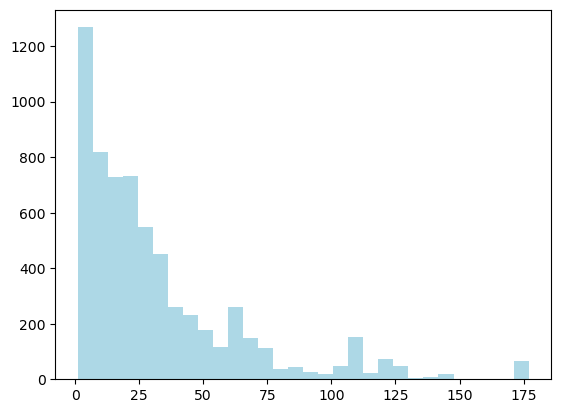

In [13]:
def plot_degree_distribution(G, network_name='',weighted=False):
    if not weighted:
        degrees = [G.degree(n) for n in G.nodes()]
        plt.hist(degrees, bins=30,color='lightblue')
        plt.title(network_name)
        plt.show()
    else:
        degrees = [G.degree(n, weight='weight') for n in G.nodes()]
        plt.hist(degrees, bins=30, label=network_name)
        plt.title(network_name)
        plt.show()

plot_degree_distribution(G)

In [54]:
def plot_log_log(G, network_name='', weighted=False, plot=True):
    '''
    takes a graph, computes log log degree distribution
    if plot is F, it returns only the r squared of the least squares applied on the log log deg dist

    param:
    -------
        * G: nx.Graph
        * network_name (optional): str, if want to give the plot a title
        * weighted (optional): bool, if  it takes into consideration the weighted degrees instead
        * plot (optional), if want to show a plot ot not
    '''
    if weighted:
        degrees = [G.degree(n, weight='weight') for n in G.nodes()]
    else:
        degrees = [G.degree(n) for n in G.nodes()]

    log_pk = np.log(np.unique(degrees, return_counts=True)[1])
    log_k = np.log(np.unique(degrees, return_counts=True)[0])

    x,y = log_k, log_pk

    # --regression (ls) line
    slope, intercept = np.polyfit(x, y, 1)
    r_squared = 1 - (sum((y - (slope * x + intercept))**2) / ((len(y) - 1) * np.var(y)))

    if plot:
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=log_k, y=log_pk, mode='markers', name='Data',marker=dict(color='#065A82')))
        fig.add_trace(go.Scatter(x=x, y=slope * x + intercept, mode='lines', name='Fit',marker=dict(color='#1b3b6f')))
        fig.update_layout(title=f"{network_name} log-log Degree Distribution", xaxis_title="log(k)", yaxis_title="log(p(k))")
        fig.update_layout( height=650, width=700)
        fig.show()

    print(f'R squared: {r_squared}')
    return r_squared

plot_log_log(G, weighted=False)

R squared: 0.5677773806981268


0.5677773806981268

In [24]:
G=nx.read_graphml('../data/graphs-5/FDR_700randomized_SVM_0.6signed_corr_Campylobacter_coli_ciprofloxacin_significant.graphml')

In [45]:
compute_network_stats(G, "m=700, cor=0.6, ANOVA, unweighted")

,|V|,|E|,density,k,k weighted,|components|,cc,s_path,d,|communities|,Q
Name,,,,,,,,,,,
"m=700, cor=0.6, ANOVA, unweighted",6428,103137,0.004993,32.089919,32.089919,196,0.778776,9.831558,26,256,0.921749


In [41]:
get_top_n_nodes(G)

In [38]:
def set_node_attributes(G:nx.Graph, clstr_attribute_df):
    '''
    Set node attributes from a dataframe to a networkx graph

    param:
    ------
    - G: nx.Graph, networkx graph
    - clstr_attribute_df: pd.DataFrame, dataframe with cluster number and attributes

    return:
    -------
    - G: nx.Graph, networkx graph with attributes set
    '''
    #make the df a dict of index clusters
    clstr_attribute_df.set_index(clstr_attribute_df.columns[0], inplace=True)

    my_dict=clstr_attribute_df[clstr_attribute_df.columns[0]].to_dict()

    attribute=clstr_attribute_df.columns[0]
    nx.set_node_attributes(G, my_dict, name=attribute)
    return G

In [ ]:
G=nx.read_graphml('../data/graphs-3/Campylobacter_coli_ciprofloxacin_cooccurence_log_odds_filtered.graphml')

In [53]:
#pangenome annot

df=pd.read_csv("../data/cluster_descriptions/cluster_pan_gene_class.csv")
df.set_index(df.columns[0], inplace=True)
my_dict = df[df.columns[0]].to_dict()
#add " " to the dict keys
my_dict = {f'"{k}"':v for k,v in my_dict.items()}
nx.set_node_attributes(G, my_dict, name="gene_class")

In [56]:
#log odds

df=pd.read_csv('../data/log_odds_nodes/Campylobacter_coli_ciprofloxacin_log_odds.csv')
df.set_index(df.columns[0], inplace=True)
my_dict = df[df.columns[0]].to_dict()
#add " " to the dict keys
my_dict = {f'"{k}"':v for k,v in my_dict.items()}
nx.set_node_attributes(G, my_dict, name="log_odds")

In [68]:
#product name

df=pd.read_csv('../data/cluster_descriptions/cluster_product.csv')
df.set_index(df.columns[0], inplace=True)
my_dict = df[df.columns[0]].to_dict()
#add " " to the dict keys
my_dict = {f'"{k}"':v for k,v in my_dict.items()}
nx.set_node_attributes(G, my_dict, name="product_name")
my_dict

{'"Cluster 0"': 'helicase, Snf2 family',
 '"Cluster 1"': 'hypothetical protein',
 '"Cluster 2"': 'hypothetical protein',
 '"Cluster 3"': 'hypothetical protein',
 '"Cluster 4"': "DNA-directed RNA polymerase beta' subunit (EC 2.7.7.6)",
 '"Cluster 5"': 'Glutamate synthase [NADPH] large chain (EC 1.4.1.13)',
 '"Cluster 6"': 'helicase, Snf2 family',
 '"Cluster 7"': 'DNA-directed RNA polymerase beta subunit (EC 2.7.7.6)',
 '"Cluster 8"': 'Type I restriction-modification system, DNA-methyltransferase subunit M (EC 2.1.1.72) / Type I restriction-modification system, specificity subunit S',
 '"Cluster 9"': 'helicase, Snf2 family',
 '"Cluster 10"': 'Type I restriction-modification system, DNA-methyltransferase subunit M (EC 2.1.1.72) / Type I restriction-modification system, specificity subunit S',
 '"Cluster 11"': 'Beta-1,3-galactosyltransferase / Beta-1,4-galactosyltransferase',
 '"Cluster 12"': 'Type I restriction-modification system, DNA-methyltransferase subunit M (EC 2.1.1.72) / Type I re

In [70]:
#patric id

df=pd.read_csv('../data/cluster_descriptions/cluster_representatives.csv')
df.set_index(df.columns[0], inplace=True)
my_dict = df[df.columns[0]].to_dict()
my_dict={f'"{k}"':v for k,v in my_dict.items()}
nx.set_node_attributes(G, my_dict, name="patric_id")
my_dict

{'"Cluster 0"': '195.2029.peg.1780',
 '"Cluster 1"': '195.2024.peg.1611',
 '"Cluster 2"': '195.2136.peg.1150',
 '"Cluster 3"': '195.2145.peg.407',
 '"Cluster 4"': '195.2024.peg.685',
 '"Cluster 5"': '195.2024.peg.1140',
 '"Cluster 6"': '195.2240.peg.1653',
 '"Cluster 7"': '195.2282.peg.946',
 '"Cluster 8"': '195.2024.peg.149',
 '"Cluster 9"': '195.2133.peg.1513',
 '"Cluster 10"': '195.2034.peg.212',
 '"Cluster 11"': '195.2118.peg.1213',
 '"Cluster 12"': '195.2102.peg.199',
 '"Cluster 13"': '195.2222.peg.937',
 '"Cluster 14"': '195.2130.peg.4',
 '"Cluster 15"': '195.2063.peg.220',
 '"Cluster 16"': '195.2138.peg.1774',
 '"Cluster 17"': '195.2179.peg.332',
 '"Cluster 18"': '195.2037.peg.1611',
 '"Cluster 19"': '195.2136.peg.1603',
 '"Cluster 20"': '195.2029.peg.727',
 '"Cluster 21"': '195.2036.peg.815',
 '"Cluster 22"': '195.2123.peg.1684',
 '"Cluster 23"': '195.2294.peg.1787',
 '"Cluster 24"': '195.2113.peg.1254',
 '"Cluster 25"': '195.2117.peg.1680',
 '"Cluster 26"': '195.2024.peg.478',

In [71]:
G.nodes(data=True)

NodeDataView({'"Cluster 0"': {'gene_class': 'accessory', 'log_odds': 1.2703651831434948, 'product_name': 'helicase, Snf2 family', 'patric_id': '195.2029.peg.1780'}, '"Cluster 80"': {'gene_class': 'accessory', 'log_odds': 1.141298669899524, 'product_name': 'Inner membrane protein forms channel for type IV secretion of T-DNA complex, VirB3 / ATPase required for both assembly of type IV secretion complex and secretion of T-DNA complex, VirB4', 'patric_id': '195.2029.peg.1806'}, '"Cluster 187"': {'gene_class': 'accessory', 'log_odds': 1.091396776877401, 'product_name': 'DNA topoisomerase III, TraE-type (EC 5.99.1.2)', 'patric_id': '195.2029.peg.1787'}, '"Cluster 383"': {'gene_class': 'accessory', 'log_odds': 0.9435153229421136, 'product_name': 'Coupling protein VirD4, ATPase required for T-DNA transfer', 'patric_id': '195.2029.peg.1793'}, '"Cluster 394"': {'gene_class': 'accessory', 'log_odds': 0.9965453264009052, 'product_name': 'hypothetical protein', 'patric_id': '195.2244.peg.1775'}, '

In [72]:
#write its as a graphml in the same location

nx.write_graphml(G, '../data/graphs-3/Campylobacter_coli_ciprofloxacin_cooccurence_log_odds_filtered_attributes.graphml')

In [46]:
G=nx.read_graphml('../data/graphs-6/corrected_200_randomized_SVM_0.4signed_corr_Campylobacter_coli_ciprofloxacin.graphml')

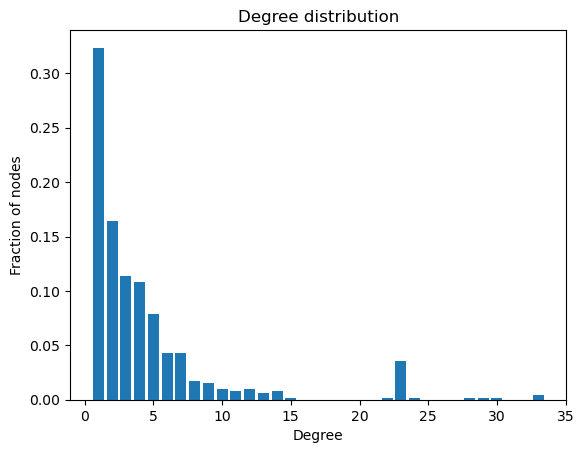

In [47]:
plot_degree_distribution(G)

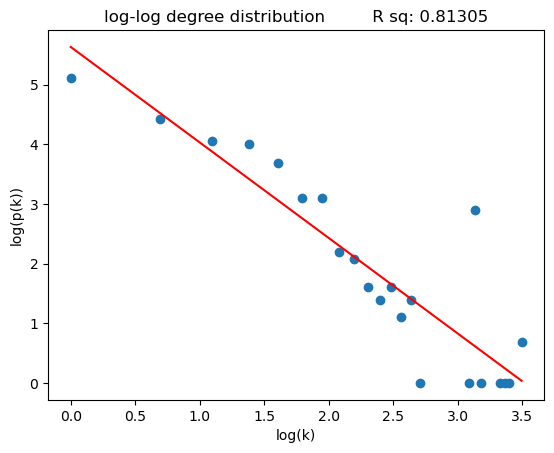

In [49]:
plot_log_log(G)

In [57]:
clstr_product_df=pd.read_csv('../data/cluster_descriptions/cluster_product.csv', index_col=0)

get_top_n_nodes(G, show_product=True, n=20)

,Degree nodes,Betweenness nodes,Closeness nodes,Eigenvector nodes,PageRank nodes,Hubs nodes,Authorities nodes
Rank,,,,,,,
1,hypothetical protein,FIG00638667: hypothetical protein,FIG00638667: hypothetical protein,hypothetical protein,FIG00638667: hypothetical protein,hypothetical protein,hypothetical protein
2,hypothetical protein,"Beta-1,3-galactosyltransferase / Beta-1,4-gala...",hypothetical protein,hypothetical protein,"3'(2'),5'-bisphosphate nucleotidase (EC 3.1.3.7)",hypothetical protein,hypothetical protein
3,hypothetical protein,hypothetical protein,hypothetical protein,hypothetical protein,FIG00472875: hypothetical protein,hypothetical protein,hypothetical protein
4,hypothetical protein,Hypothetical protein Cj1505c,hypothetical protein,"terminase B protein, putative",hypothetical protein,"terminase B protein, putative",hypothetical protein
5,Oxygen-insensitive NAD(P)H nitroreductase (EC ...,hypothetical protein,hypothetical protein,hypothetical protein,Ribosomal RNA adenine dimethylase,hypothetical protein,hypothetical protein
6,FIG00005326: uncharacterized protein,Putative transporter,Phosphoglycerate transporter protein PgtP,hypothetical protein,Ribosomal RNA adenine dimethylase,hypothetical protein,"terminase B protein, putative"
7,hypothetical protein,Glucose-1-phosphate thymidylyltransferase (EC ...,hypothetical protein,hypothetical protein,Hemerythrin domain protein,hypothetical protein,hypothetical protein
8,hypothetical protein,Integral membrane protein,"membrane protein , putative",hypothetical protein,Argininosuccinate synthase (EC 6.3.4.5),hypothetical protein,hypothetical protein
9,hypothetical protein,"dTDP-glucose 4,6-dehydratase (EC 4.2.1.46)",Glucose-1-phosphate thymidylyltransferase (EC ...,hypothetical protein,4-hydroxy-tetrahydrodipicolinate synthase (EC ...,hypothetical protein,hypothetical protein


In [5]:
test ='pangenome-repo/Pangenome-Analysis-Workflow/genome_ids'

# get basename
import os
os.path.basename(test)
os.path.dirname(test)

'pangenome-repo/Pangenome-Analysis-Workflow'